# 咽部分类

## 模块导入

In [2]:
import os
import sys
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

import shutil
import random
import glob
import pandas as pd
import cv2
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.applications import MobileNetV2, MobileNet
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, model_from_json
from tensorflow.keras.optimizers import SGD,Adam

# 添加路径，以能正常导入mbsh、trainer
sys.path.insert(0, r"..\Lib\trainer")

from mbsh.core.images import fetch_all_files, read_img_file, resize_image,save_img_file

from mbsh import create_app
from mbsh.core.models import SmallModel
from mbsh.core.images import read_to_pd,TrainArgs
from mbsh.core.plot import Plot

from trainer import Trainer

2022-05-30 10:11:51,720 - INFO - __init__.py - init_logger - 58 - ini  logger file D:\projects\Vision\Lib\logs\kernel-ea2815d1-c012-4303-a357-a4ab637b98c4.log


use temp dir:d:\znyx\temp


In [8]:
## 训练配置
# 样本数据根目录
# 根目录下res中按分类标签存放各类型图像
# cache目录存放训练的结果模型

root_path = r"\\192.168.0.154\数据\口咽部\大部位27分类"
""
#是否使用平衡数据做训练
use_increase = False

#训练采用的模型名称
model_name = 'vgg'

unfreeze_layers = 179

# 模型保存id
model_id = 2803

# 数据库中记录条目的name
sm_name = ''

# 如果数据库还未建立相应的记录可查询一个已存在的，再自行修改sm的desc_list

sm_desc_list =  ["不确定", "食管", "贲门", "前壁", "后壁", "大弯", "小弯侧", "前壁",  
                "后壁","小弯","大弯侧","前壁","后壁","小弯","大弯侧",  
                 "十二指肠球部", "十二指肠降部","后壁","前壁","小弯侧","前壁","后壁",  
                 "小弯","前壁","后壁","大弯","小弯侧","咽部"]


# 数据划分为验证集的比例
split_ratio = 0.15

#过程尺寸
# img_process_size = (480,480)

# 训练图像大小，默认是(224,224)
img_size = (224,224)

# img_size = (360,360)
# 训练迭代次数
epochs = 20
## 训练配置
# 训练每批次样本数
batch_size = 16

# 初始化

In [9]:
# app创建
app = create_app(os.getenv('FLASK_CONFIG') or 'default')
app.app_context().push()

2022-05-30 10:15:08,182 - INFO - __init__.py - create_app - 71 - db url =sqlite:///D:\projects\Vision\Lib\trainer\../data\production.db


In [10]:
cache_path = root_path + '/cache'
res_path = root_path + '/res'

# res数据分割后的训练和验证集目录
res_train_path = root_path + '/res_train'
res_test_path = root_path + '/res_val'

# 数据平衡后的训练和验证集目录
train_path = root_path + '/train'
test_path = root_path + '/test'
cache_path
# 图片预测错误存放目录
pred_err_path = root_path + '/pred_err_vgg16'

# trainer创建

# 从数据库获取model信息，如果数据库还未建立相应的记录可查询一个已存在的，再自行修改sm的desc_list
# sm = SmallModel.query.get(sm_name)

sm = SmallModel(sm_name)
sm.desc_list = sm_desc_list
trainer = Trainer(sm)
trainer.img_size = img_size
trainer.target_fold = root_path

# 类型个数
types_num = len(trainer.desc_list)

desc_list = [str(x) + '-' + trainer.desc_list[x] for x in range(0,types_num)]
print(desc_list)

['0-不确定', '1-食管', '2-贲门', '3-前壁', '4-后壁', '5-大弯', '6-小弯侧', '7-前壁', '8-后壁', '9-小弯', '10-大弯侧', '11-前壁', '12-后壁', '13-小弯', '14-大弯侧', '15-十二指肠球部', '16-十二指肠降部', '17-后壁', '18-前壁', '19-小弯侧', '20-前壁', '21-后壁', '22-小弯', '23-前壁', '24-后壁', '25-大弯', '26-小弯侧', '27-咽部']


## 推理&绘图

In [11]:
model_id

2803

In [12]:
model = trainer.load_model(model_id)

2022-05-30 10:15:19,341 - DEBUG - attrs.py - __getitem__ - 77 - Creating converter from 3 to 5
2022-05-30 10:15:25,376 - INFO - trainer.py - load_model - 545 - load weights 2803


In [13]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

C:\ProgramData\Anaconda3\lib\site-packages\keras\backend.py:450: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '
2022-05-30 13:35:50,510 - INFO - trainer.py - load_model - 545 - load weights 2803
2022-05-30 13:35:50,513 - DEBUG - images.py - sort_by_file_name - 354 - sort_by_file_name dirs=['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27']


find 28 from \\192.168.0.154\数据\口咽部\大部位27分类\res_test
load data from fold finished ,count=7560
237/237 [==============================] - 22s 92ms/step
cast-461ms, fold: ['\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test'] ,accurracy:81


2022-05-30 13:36:58,481 - DEBUG - colorbar.py - _get_ticker_locator_formatter - 620 - locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x000001E44DD59F70>
2022-05-30 13:36:58,482 - DEBUG - colorbar.py - update_ticks - 665 - Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x000001E44DD59F70> on colorbar
2022-05-30 13:36:58,483 - DEBUG - colorbar.py - _add_solids_pcolormesh - 794 - Setting pcolormesh


Confusion matrix, without normalization


2022-05-30 13:36:59,367 - INFO - plot.py - show_matrix - 164 - save plot image to \\192.168.0.154\数据\口咽部\大部位27分类\2022-05-30-13-36_689.jpg 
2022-05-30 13:36:59,371 - INFO - plot.py - show_matrix - 180 - accurracy:0.8183862433862434


[[146  14  27   3   0   4   4   8   3   6   1   1   0   0   0   0   1   1
    0   0   0   0   0   0   0   0   0  51]
 [  2 236  26   0   0   0   0   1   2   1   0   0   0   0   0   0   1   0
    0   0   0   0   0   1   0   0   0   0]
 [  2  15 250   0   0   0   0   1   2   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  1   0   1 200  22  28   5   1   0  10   2   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  3   0   0  27 231   1   6   0   0   1   1   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0  15   1 230  19   2   0   0   0   3   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  1   1   1   2   9  28 226   2   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  8   0   0   0   0   1   2 244   9   2   0   1   0   0   0   1   0   0
    1   0   0   0   0   0   0   0   1   0]
 [  3   0   0   0   1   0   1   4 261   0   0   0   0   0   0   

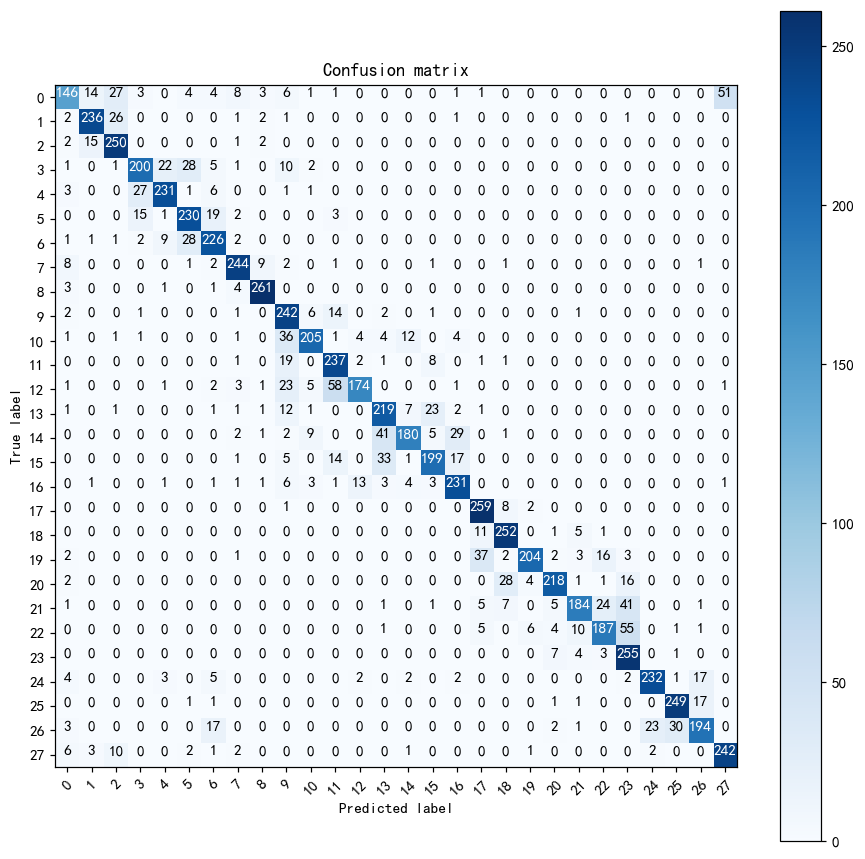

['0-不确定', '1-食管', '2-贲门', '3-前壁', '4-后壁', '5-大弯', '6-小弯侧', '7-前壁', '8-后壁', '9-小弯', '10-大弯侧', '11-前壁', '12-后壁', '13-小弯', '14-大弯侧', '15-十二指肠球部', '16-十二指肠降部', '17-后壁', '18-前壁', '19-小弯侧', '20-前壁', '21-后壁', '22-小弯', '23-前壁', '24-后壁', '25-大弯', '26-小弯侧', '27-咽部']


In [18]:
K.set_learning_phase(0)
model = trainer.load_model(model_id)
# 加载训练中的最优模型
use_increase = False
# 显示预测准确度、混淆矩阵，保持混淆矩阵图到root_path
acc, y_pred, y_true, file_test, _ = trainer.predict_data([r"\\192.168.0.154\数据\口咽部\大部位27分类\res_test"], model = model)

path = Plot.show_matrix(y_pred, y_true, types_num, root_path, fig_size=10)
plt.show()
print(desc_list)

## 硬盘加载

In [5]:
import cv2
def img_rgb2_bgr(img):
    img = img[:,:, : : -1]
    return img

# 图片生成器
train_datagen =  ImageDataGenerator(       
        width_shift_range = 0.15,
        height_shift_range = 0.15,
        shear_range = 0,
        rotation_range = 10,
        zoom_range = 0.1,
        fill_mode='constant',
        vertical_flip=False,
        horizontal_flip=False,
        preprocessing_function = img_rgb2_bgr,
    )

test_datagen =  ImageDataGenerator(
        fill_mode='constant',
        preprocessing_function = img_rgb2_bgr,
    )

# 训练数据与测试数据
cls_mode = 'binary' if types_num == 2 else 'categorical'
train_generator = train_datagen.flow_from_directory(
        res_train_path,
        target_size = img_size,
        batch_size = batch_size,
        class_mode = cls_mode)
test_generator = test_datagen.flow_from_directory(
        res_test_path,
        target_size = img_size,
        batch_size = batch_size,
        class_mode = cls_mode)

train_samples = train_generator.samples
valid_samples = test_generator.samples

Found 70552 images belonging to 28 classes.
Found 7395 images belonging to 28 classes.


In [6]:
def fit_gen(model, model_id, epochs = 5):
    class_mode = 'binary' if types_num == 2 else 'categorical'
    print("train from imgs model_id=%s ,class_mode=%s" % (model_id, class_mode))
                
    # 创建cache目录
    if not os.path.exists(cache_path):
        os.mkdir(cache_path)
    
    weight_path = cache_path + '/weights' + str(model_id) + '.hdf5'
    
    # EarlyStoppingy原型：
    # EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
    early_stop = EarlyStopping(monitor='val_loss', patience = 8)
    
    # ModelCheckpoint原型：
    # ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
    check_point = ModelCheckpoint(weight_path, monitor='val_loss', save_best_only=True, save_weights_only=True)
    
    # callbacks设置
    callbacks = [early_stop, check_point]
    
    
    history = model.fit_generator(
        train_generator,
        epochs = epochs,
        steps_per_epoch = train_samples // batch_size,
        validation_data = test_generator,
        validation_steps = valid_samples // batch_size,
        callbacks = callbacks)
    return history

## 训练

#### 创建模型

In [7]:
trainer.model_type = model_name
model = trainer.create_model(unfreeze_layers=unfreeze_layers )
model.summary()

create vgg model, unfreeze_layers 179
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56

In [8]:
len(model.layers)

23

In [9]:
sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

#### 训练

In [10]:
model_id

2803

In [11]:
# 训练
K.set_learning_phase(1)
history = fit_gen(model, model_id, epochs =50)
#保存
trainer.save_model(model, model_id)

train from imgs model_id=2803 ,class_mode=categorical
Epoch 1/50
4408/4409 [============================>.] - ETA: 0s - loss: 0.7813 - acc: 0.7399WARNING:tensorflow:This model was compiled with a Keras optimizer (<tensorflow.python.keras.optimizers.SGD object at 0x000001EF000EA710>) but is being saved in TensorFlow format with `save_weights`. The model's weights will be saved, but unlike with TensorFlow optimizers in the TensorFlow format the optimizer's state will not be saved.

Consider using a TensorFlow optimizer from `tf.train`.


2022-05-29 05:45:18,083 - WARNING - tf_logging.py - warning - 125 - This model was compiled with a Keras optimizer (<tensorflow.python.keras.optimizers.SGD object at 0x000001EF000EA710>) but is being saved in TensorFlow format with `save_weights`. The model's weights will be saved, but unlike with TensorFlow optimizers in the TensorFlow format the optimizer's state will not be saved.

Consider using a TensorFlow optimizer from `tf.train`.


4409/4409 [==============================] - 743s 168ms/step - loss: 0.7812 - acc: 0.7399 - val_loss: 0.4817 - val_acc: 0.8362
Epoch 2/50
4408/4409 [============================>.] - ETA: 0s - loss: 0.4737 - acc: 0.8343WARNING:tensorflow:This model was compiled with a Keras optimizer (<tensorflow.python.keras.optimizers.SGD object at 0x000001EF000EA710>) but is being saved in TensorFlow format with `save_weights`. The model's weights will be saved, but unlike with TensorFlow optimizers in the TensorFlow format the optimizer's state will not be saved.

Consider using a TensorFlow optimizer from `tf.train`.


2022-05-29 05:57:13,992 - WARNING - tf_logging.py - warning - 125 - This model was compiled with a Keras optimizer (<tensorflow.python.keras.optimizers.SGD object at 0x000001EF000EA710>) but is being saved in TensorFlow format with `save_weights`. The model's weights will be saved, but unlike with TensorFlow optimizers in the TensorFlow format the optimizer's state will not be saved.

Consider using a TensorFlow optimizer from `tf.train`.


4409/4409 [==============================] - 715s 162ms/step - loss: 0.4736 - acc: 0.8343 - val_loss: 0.3955 - val_acc: 0.8594
Epoch 3/50
4408/4409 [============================>.] - ETA: 0s - loss: 0.3992 - acc: 0.8582WARNING:tensorflow:This model was compiled with a Keras optimizer (<tensorflow.python.keras.optimizers.SGD object at 0x000001EF000EA710>) but is being saved in TensorFlow format with `save_weights`. The model's weights will be saved, but unlike with TensorFlow optimizers in the TensorFlow format the optimizer's state will not be saved.

Consider using a TensorFlow optimizer from `tf.train`.


2022-05-29 06:09:13,869 - WARNING - tf_logging.py - warning - 125 - This model was compiled with a Keras optimizer (<tensorflow.python.keras.optimizers.SGD object at 0x000001EF000EA710>) but is being saved in TensorFlow format with `save_weights`. The model's weights will be saved, but unlike with TensorFlow optimizers in the TensorFlow format the optimizer's state will not be saved.

Consider using a TensorFlow optimizer from `tf.train`.


4409/4409 [==============================] - 720s 163ms/step - loss: 0.3992 - acc: 0.8582 - val_loss: 0.3800 - val_acc: 0.8703
Epoch 4/50
4408/4409 [============================>.] - ETA: 0s - loss: 0.3503 - acc: 0.8742WARNING:tensorflow:This model was compiled with a Keras optimizer (<tensorflow.python.keras.optimizers.SGD object at 0x000001EF000EA710>) but is being saved in TensorFlow format with `save_weights`. The model's weights will be saved, but unlike with TensorFlow optimizers in the TensorFlow format the optimizer's state will not be saved.

Consider using a TensorFlow optimizer from `tf.train`.


2022-05-29 06:21:11,867 - WARNING - tf_logging.py - warning - 125 - This model was compiled with a Keras optimizer (<tensorflow.python.keras.optimizers.SGD object at 0x000001EF000EA710>) but is being saved in TensorFlow format with `save_weights`. The model's weights will be saved, but unlike with TensorFlow optimizers in the TensorFlow format the optimizer's state will not be saved.

Consider using a TensorFlow optimizer from `tf.train`.


4409/4409 [==============================] - 718s 163ms/step - loss: 0.3503 - acc: 0.8742 - val_loss: 0.3684 - val_acc: 0.8731
Epoch 5/50
4408/4409 [============================>.] - ETA: 0s - loss: 0.3130 - acc: 0.8876WARNING:tensorflow:This model was compiled with a Keras optimizer (<tensorflow.python.keras.optimizers.SGD object at 0x000001EF000EA710>) but is being saved in TensorFlow format with `save_weights`. The model's weights will be saved, but unlike with TensorFlow optimizers in the TensorFlow format the optimizer's state will not be saved.

Consider using a TensorFlow optimizer from `tf.train`.


2022-05-29 06:33:06,033 - WARNING - tf_logging.py - warning - 125 - This model was compiled with a Keras optimizer (<tensorflow.python.keras.optimizers.SGD object at 0x000001EF000EA710>) but is being saved in TensorFlow format with `save_weights`. The model's weights will be saved, but unlike with TensorFlow optimizers in the TensorFlow format the optimizer's state will not be saved.

Consider using a TensorFlow optimizer from `tf.train`.


4409/4409 [==============================] - 714s 162ms/step - loss: 0.3130 - acc: 0.8876 - val_loss: 0.3571 - val_acc: 0.8770
Epoch 6/50
4408/4409 [============================>.] - ETA: 0s - loss: 0.2797 - acc: 0.8982WARNING:tensorflow:This model was compiled with a Keras optimizer (<tensorflow.python.keras.optimizers.SGD object at 0x000001EF000EA710>) but is being saved in TensorFlow format with `save_weights`. The model's weights will be saved, but unlike with TensorFlow optimizers in the TensorFlow format the optimizer's state will not be saved.

Consider using a TensorFlow optimizer from `tf.train`.


2022-05-29 06:45:17,467 - WARNING - tf_logging.py - warning - 125 - This model was compiled with a Keras optimizer (<tensorflow.python.keras.optimizers.SGD object at 0x000001EF000EA710>) but is being saved in TensorFlow format with `save_weights`. The model's weights will be saved, but unlike with TensorFlow optimizers in the TensorFlow format the optimizer's state will not be saved.

Consider using a TensorFlow optimizer from `tf.train`.


4409/4409 [==============================] - 731s 166ms/step - loss: 0.2796 - acc: 0.8982 - val_loss: 0.3456 - val_acc: 0.8766
Epoch 7/50
4408/4409 [============================>.] - ETA: 0s - loss: 0.2551 - acc: 0.9066WARNING:tensorflow:This model was compiled with a Keras optimizer (<tensorflow.python.keras.optimizers.SGD object at 0x000001EF000EA710>) but is being saved in TensorFlow format with `save_weights`. The model's weights will be saved, but unlike with TensorFlow optimizers in the TensorFlow format the optimizer's state will not be saved.

Consider using a TensorFlow optimizer from `tf.train`.


2022-05-29 06:57:26,469 - WARNING - tf_logging.py - warning - 125 - This model was compiled with a Keras optimizer (<tensorflow.python.keras.optimizers.SGD object at 0x000001EF000EA710>) but is being saved in TensorFlow format with `save_weights`. The model's weights will be saved, but unlike with TensorFlow optimizers in the TensorFlow format the optimizer's state will not be saved.

Consider using a TensorFlow optimizer from `tf.train`.


4409/4409 [==============================] - 729s 165ms/step - loss: 0.2551 - acc: 0.9066 - val_loss: 0.3405 - val_acc: 0.8849
Epoch 8/50
4408/4409 [============================>.] - ETA: 0s - loss: 0.2300 - acc: 0.9158WARNING:tensorflow:This model was compiled with a Keras optimizer (<tensorflow.python.keras.optimizers.SGD object at 0x000001EF000EA710>) but is being saved in TensorFlow format with `save_weights`. The model's weights will be saved, but unlike with TensorFlow optimizers in the TensorFlow format the optimizer's state will not be saved.

Consider using a TensorFlow optimizer from `tf.train`.


2022-05-29 07:08:39,179 - WARNING - tf_logging.py - warning - 125 - This model was compiled with a Keras optimizer (<tensorflow.python.keras.optimizers.SGD object at 0x000001EF000EA710>) but is being saved in TensorFlow format with `save_weights`. The model's weights will be saved, but unlike with TensorFlow optimizers in the TensorFlow format the optimizer's state will not be saved.

Consider using a TensorFlow optimizer from `tf.train`.


4409/4409 [==============================] - 672s 153ms/step - loss: 0.2300 - acc: 0.9158 - val_loss: 0.3394 - val_acc: 0.8880
Epoch 9/50
4408/4409 [============================>.] - ETA: 0s - loss: 0.2127 - acc: 0.9221WARNING:tensorflow:This model was compiled with a Keras optimizer (<tensorflow.python.keras.optimizers.SGD object at 0x000001EF000EA710>) but is being saved in TensorFlow format with `save_weights`. The model's weights will be saved, but unlike with TensorFlow optimizers in the TensorFlow format the optimizer's state will not be saved.

Consider using a TensorFlow optimizer from `tf.train`.


2022-05-29 07:19:52,894 - WARNING - tf_logging.py - warning - 125 - This model was compiled with a Keras optimizer (<tensorflow.python.keras.optimizers.SGD object at 0x000001EF000EA710>) but is being saved in TensorFlow format with `save_weights`. The model's weights will be saved, but unlike with TensorFlow optimizers in the TensorFlow format the optimizer's state will not be saved.

Consider using a TensorFlow optimizer from `tf.train`.


4409/4409 [==============================] - 674s 153ms/step - loss: 0.2126 - acc: 0.9221 - val_loss: 0.3298 - val_acc: 0.8907
Epoch 10/50
4409/4409 [==============================] - 669s 152ms/step - loss: 0.1940 - acc: 0.9290 - val_loss: 0.3905 - val_acc: 0.8776
Epoch 11/50
4409/4409 [==============================] - 675s 153ms/step - loss: 0.1800 - acc: 0.9336 - val_loss: 0.3785 - val_acc: 0.8814
Epoch 12/50
4409/4409 [==============================] - 706s 160ms/step - loss: 0.1648 - acc: 0.9396 - val_loss: 0.4025 - val_acc: 0.8827
Epoch 13/50
4409/4409 [==============================] - 744s 169ms/step - loss: 0.1520 - acc: 0.9442 - val_loss: 0.3996 - val_acc: 0.8819
Epoch 14/50
4409/4409 [==============================] - 719s 163ms/step - loss: 0.1383 - acc: 0.9496 - val_loss: 0.3940 - val_acc: 0.8843
Epoch 15/50
4409/4409 [==============================] - 711s 161ms/step - loss: 0.1262 - acc: 0.9531 - val_loss: 0.4206 - val_acc: 0.8857
Epoch 16/50
4409/4409 [================

2022-05-29 08:53:51,604 - INFO - trainer.py - save_model - 595 - save model success ,num=2803


In [13]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
# show images inline
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

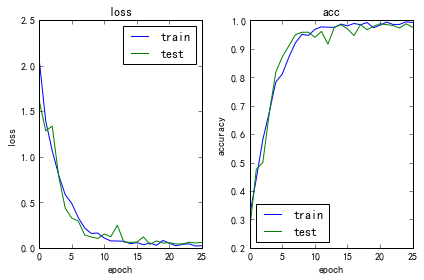

In [14]:
def show_history(history):
    fig, axes = plt.subplots(nrows=1,ncols=2)
    ax=axes[0]

    ax.plot(history['loss'])
    ax.plot(history['val_loss'])
    ax.legend(['train','test'],loc='upper right')
    ax.set_title('loss'.format(1))
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')

    ax=axes[1]
    ax.plot(history['acc'])
    ax.plot(history['val_acc'])
    ax.legend(['train','test'],loc='best')
    ax.set_title('acc'.format(1))
    ax.set_xlabel('epoch')
    ax.set_ylabel('accuracy')
    fig.tight_layout()
    plt.savefig(os.path.join(root_path,"训练曲线.png"))
#     plt.savefig("训练曲线.png")
    plt.show() 
    
show_history(history.history)

#### 查看训练结果

In [15]:
def read_img(path):
    img = cv2.imdecode(np.fromfile(path, dtype=np.uint8), cv2.IMREAD_UNCHANGED) #cv2.imread(path)
#     img = cv2.resize(img, (224, 224), cv2.INTER_LINEAR)
    img = cv2.resize(img, (224, 224))
    return img

In [16]:
model_id

800

In [17]:
model = trainer.load_model(model_id)

2022-03-14 10:59:02,840 - INFO - trainer.py - load_model - 603 - load weights 800


In [16]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [17]:
imgs_dir = r"E:\projects\znyx-trainer\job\口咽部\第3轮\训练集\valid_data\1"

i=0
for file in os.listdir(imgs_dir):
    img_path = os.path.join(imgs_dir,file)
    img = read_img_file(img_path)
    img_resize = cv2.resize(img,(224,224))
    
    X = np.asarray([img_resize])
    predicitons_list = model.predict(X, verbose=0)[0]
    class_index = np.argmax(predicitons_list)
    confidence = np.max(predicitons_list)
    if class_index == 2:
        i+=1
        print(file+' 识别为咽后壁 '+' 概率为 '+str(confidence))
        print(predicitons_list)
print('识别为咽后壁总数为'+str(i))

202106241553#20210810112536202.jpg 识别为咽后壁  概率为 0.7988816
[6.8384267e-08 2.0111836e-01 7.9888159e-01 1.5652894e-11 1.7322208e-11]
识别为咽后壁总数为1


In [26]:
imgs_dir = r"E:\projects\znyx-trainer\job\口咽部\第3轮\训练集\valid_data\4"
save_dir = r"E:\projects\znyx-trainer\job\口咽部\第3轮\训练集\valid_data\左梨状窝识别成右梨状窝"

num = 0
for file in os.listdir(imgs_dir):
    img_path = os.path.join(imgs_dir,file)
    save_path = os.path.join(save_dir,file)
    img = read_img_file(img_path)
    img_resize = cv2.resize(img,(224,224))
    
    X = np.asarray([img_resize])
    predicitons_list = model.predict(X, verbose=0)[0]
    class_index = np.argmax(predicitons_list)
    confidence = np.max(predicitons_list)
    if class_index == 3:
        num+=1
        print(file+' 识别为右梨状窝 '+' 概率为 '+str(confidence))
        save_img_file(save_path,img)
print('识别为右梨状窝总数为'+str(num))

01.0000000052746.0070.1521692741_f5850.jpg 识别为右梨状窝  概率为 0.66510105
1-食管_0_c87&001_0_001_2021_04_01_10_01_361.jpg 识别为右梨状窝  概率为 0.974855
2-贲门_0_c1&001_0_001_2021_05_06_09_18_557.jpg 识别为右梨状窝  概率为 0.82600063
2-贲门_0_c15&001_0_001_2021_06_18_11_20_652.jpg 识别为右梨状窝  概率为 0.9473039
202106240992#20210809134616945.jpg 识别为右梨状窝  概率为 0.6716578
202107290759#20210816103405438.jpg 识别为右梨状窝  概率为 0.9797661
202107292058#2021080309443241.jpg 识别为右梨状窝  概率为 0.8339881
202108021340#20210817111359827.jpg 识别为右梨状窝  概率为 0.9704851
202108111385#2021081309222036.jpg 识别为右梨状窝  概率为 0.8538319
202108131023#20210819140353533.jpg 识别为右梨状窝  概率为 0.9809533
202108232761#202108251047076252.jpg 识别为右梨状窝  概率为 0.6130641
202109071284#202109080824112591.jpg 识别为右梨状窝  概率为 0.7829636
202109100884#20210911105212063.jpg 识别为右梨状窝  概率为 0.949892
202109132333#20210928093401887.jpg 识别为右梨状窝  概率为 0.9006658
202109160763#20210923134301634.jpg 识别为右梨状窝  概率为 0.9462431
202109201640#20210923134421887.jpg 识别为右梨状窝  概率为 0.8749532
202109301698#202110061035053122.

2022-03-14 10:59:22,936 - INFO - trainer.py - load_model - 603 - load weights 800


find 5 from E:\projects\znyx-trainer\job\口咽部\第7轮_整图\valid_date
load data from fold finished ,count=181
181/181 [==============================] - 3s 14ms/step


2022-03-14 10:59:28,693 - INFO - plot.py - show_matrix - 222 - save plot image to E:\projects\znyx-trainer\job\口咽部\第8轮\2022-03-14-10-59_498.png 
2022-03-14 10:59:28,694 - INFO - plot.py - show_matrix - 238 - accurracy:0.988950276243094


cast-395ms, fold: ['E:\\projects\\znyx-trainer\\job\\口咽部\\第7轮_整图\\valid_date'] ,accurracy:98
Confusion matrix, without normalization
[[90  0  0  0  0]
 [ 0 25  1  0  0]
 [ 0  0 30  0  0]
 [ 0  0  0 26  0]
 [ 0  0  1  0  8]]
00 acc: 100.00%
01 acc: 96.15%
02 acc: 100.00%
03 acc: 100.00%
04 acc: 88.89%
overall acc: 98.90%, avg acc: 97.01%


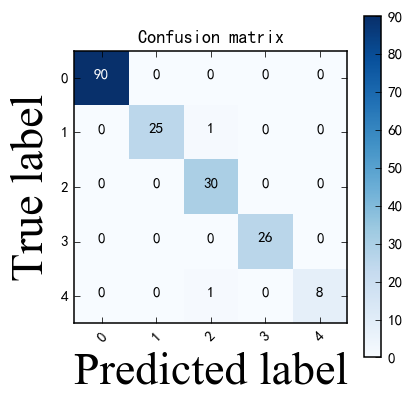

['0-喉', '1-上颚', '2-咽后壁', '3-右梨状窝', '4-左梨状窝']


In [18]:
K.set_learning_phase(0)
model = trainer.load_model(model_id)
# 加载训练中的最优模型
use_increase = False
# 显示预测准确度、混淆矩阵，保持混淆矩阵图到root_path
acc, y_pred, y_true, file_test,_,_ = trainer.predict_data([r"E:\projects\znyx-trainer\job\口咽部\第7轮_整图\valid_date"], model = model)

path = Plot.show_matrix(y_pred, y_true, types_num, root_path)
plt.show()
print(desc_list)

find 5 from E:\projects\znyx-trainer\job\口咽部\第2轮\训练集\imgs_valid
load data from fold finished ,count=295
295/295 [==============================] - 1s 2ms/step
cast-565ms, fold: ['E:\\projects\\znyx-trainer\\job\\口咽部\\第2轮\\训练集\\imgs_valid'] ,accurracy:88
Confusion matrix, without normalization


2022-01-24 14:16:26,546 - INFO - plot.py - show_matrix - 222 - save plot image to E:\projects\znyx-trainer\job\口咽部\第3轮\训练集\2022-01-24-14-16_689.png 
2022-01-24 14:16:26,548 - INFO - plot.py - show_matrix - 238 - accurracy:0.8847457627118644


[[90  0  0  0  0]
 [ 0 19  1  0  0]
 [ 1  1 56  0  2]
 [ 0  0  0 67  8]
 [ 1  0  0 20 29]]
00 acc: 100.00%
01 acc: 95.00%
02 acc: 93.33%
03 acc: 89.33%
04 acc: 58.00%
overall acc: 88.47%, avg acc: 87.13%


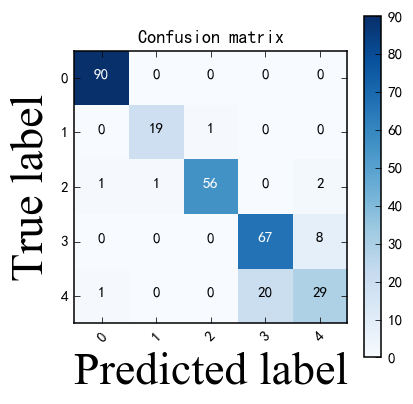

['0-喉', '1-上颚', '2-咽后壁', '3-右梨状窝', '4-左梨状窝']


In [23]:
K.set_learning_phase(0)
# model = trainer.load_model(50)
# 加载训练中的最优模型
use_increase = False
# 显示预测准确度、混淆矩阵，保持混淆矩阵图到root_path
acc, y_pred, y_true, file_test,_,_ = trainer.predict_data([r"E:\projects\znyx-trainer\job\口咽部\第2轮\训练集\imgs_valid"], model = model)

path = Plot.show_matrix(y_pred, y_true, types_num, root_path)
plt.show()
print(desc_list)

In [40]:
import time
pred_err_out = 1
def test_fold(to_chk_path, binary_threshold = 0.8):
    to_check_path_result = to_chk_path + '_result_' + time.strftime("%y%m%d_%H%M%S", time.localtime(time.time()))
    if not os.path.exists(to_check_path_result):
        os.makedirs(to_check_path_result)
        
    acc, y_pred, y_true, file_test, predicts,_ = trainer.predict_data([to_chk_path], model=model,
                                                                    binary_threshold=binary_threshold)

    if pred_err_out:
        # 输出预测错误图片到pred_err_path
        trainer.extract_files(file_test, y_pred, y_true, to_check_path_result)
    path = Plot.show_matrix(y_pred, y_true, types_num, to_check_path_result)
    if types_num == 2:
        Plot.get_roc(y_true, predicts, to_check_path_result)
    plt.show()
    print(desc_list)
    return y_pred

find 3 from E:\projects\znyx-trainer\job\HuaLu_FenLei/test
load data from fold finished ,count=176
176/176 [==============================] - 1s 3ms/step
cast626ms, fold: ['E:\\projects\\znyx-trainer\\job\\HuaLu_FenLei/test'] ,accurracy:94
extract 9 files to E:\projects\znyx-trainer\job\HuaLu_FenLei/test_result_210723_172213 finished


2021-07-23 17:22:20,993 - INFO - plot.py - show_matrix - 222 - save plot image to E:\projects\znyx-trainer\job\HuaLu_FenLei\test_result_210723_172213\2021-07-23-17-22_966.png 
2021-07-23 17:22:20,994 - INFO - plot.py - show_matrix - 238 - accurracy:0.9488636363636364


Confusion matrix, without normalization
[[57  0  0]
 [ 0 39  1]
 [ 2  6 71]]
00 acc: 100.00%
01 acc: 97.50%
02 acc: 89.87%
overall acc: 94.89%, avg acc: 95.79%


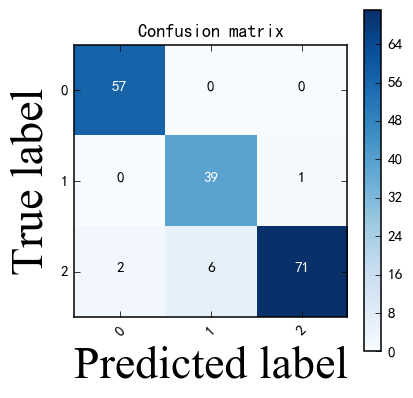

['0-非胃癌', '1-典型性管状腺癌', '2-典型性黏液腺癌']


In [41]:
y_pred = test_fold(test_path)